# $\textit{Clasificación de texto}$

Utilizaremos el *dataset* *Twenty News Groups*

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
from collections import Counter
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import gensim
import os, re, csv, math, codecs

In [ ]:
from pprint import pprint
pprint(newsgroups_train.target_names)
pprint(newsgroups_train.target)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']
array([7, 4, 4, ..., 3, 1, 8])


Creamos *tokens* a partir del texto de TNG

In [ ]:
token=Tokenizer(num_words=30000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token="UNK", document_count=0)

In [ ]:
token.fit_on_texts(newsgroups_train.data)

In [ ]:
train_sequences=token.texts_to_sequences(newsgroups_train.data)
test_sequences=token.texts_to_sequences(newsgroups_test.data)


"Padeamos" la secuencia para que tenga un largo máximo de palabras a analizar

In [ ]:
max_len=500
train_sequences=pad_sequences(train_sequences, maxlen=max_len)
test_sequences=pad_sequences(test_sequences, maxlen=max_len)


Obtenemos la representacion vectorial de cada *token* que pertenecen a los textos a categorizar y que se encuentran dentro del *embedding* de referencia fasttext

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    EMBEDDING_DIR = "/content/drive/MyDrive/RedesNeuronales/2/Embeddings/fasttext/"
except:
    EMBEDDING_DIR = "./"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
reverse_dictionary = token.index_word
dictionary = dict([(value, key) for (key, value) in reverse_dictionary.items()])


In [ ]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open(EMBEDDING_DIR+'wiki-news-300d-1M.vec', encoding='utf-8')
for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...
found 999995 word vectors


In [ ]:
embed_dim=300
num_words=len(dictionary)+1
embedding_matrix = np.zeros([num_words, embed_dim])
for word, idx in dictionary.items():
  if idx <= num_words and word in embeddings_index:
    embedding_matrix[idx,:]=embeddings_index[word]

# $\textit{Embedding + CNN + Attention}$

In [ ]:
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Input, Concatenate, Dot, RepeatVector, TimeDistributed, Multiply, Lambda, Flatten, Activation, Reshape, BatchNormalization
import tensorflow.keras.backend as K
from tensorflow.keras.activations import softmax
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

#Creamos una softmax que se aplica a lo largo de la anteultima dimension, es decir, a lo largo la representacion de cada palabra.
def softMaxOverTime(x):
    return softmax(x,axis=1)

nb_words = num_words
value_dim = 32 #Cantidad de filtros del contextualizador

input_layer = Input(shape=(max_len, )) #Entrada de texto de largo 500 maximo.

#Creamos un embedding de len(vocab) x tamaño de la representacion de cada palabra, usando el embedding descargado como pesos de la representacion de las palabras, con un largo maximo como entrada.
embedding_layer = Embedding(nb_words, embed_dim, weights = [embedding_matrix], input_length = max_len, trainable = True)(input_layer)

#Contextualizador, aca esta lo que proyecta el vector de entrada con el query que son los pesos de los filtros.
conv_out = Conv1D(filters = value_dim, kernel_size = 8, activation = "tanh", padding = "same")(embedding_layer)
conv_out = BatchNormalization()(conv_out)
conv_out = Conv1D(filters = value_dim, kernel_size = 4, activation = "tanh", padding = "same")(conv_out)
conv_out = BatchNormalization()(conv_out)
conv_out = Dropout(0.3)(conv_out)
ulog_attention = Dense(1, activation="linear")(conv_out)

#La parte de attention
attention = Activation(softMaxOverTime)(ulog_attention)
repeated_attention = TimeDistributed(RepeatVector(value_dim))(attention)
repeated_attention = Reshape([max_len, value_dim])(repeated_attention)

#Aca esta la parte de value
weighted_embeddings = Multiply()([repeated_attention, conv_out])
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

#Salida
dense1 = Dense(100, activation='relu')(embedding_sum)
dense2 = Dense(20, activation='softmax')(dense1)
model = Model(input_layer, dense2)


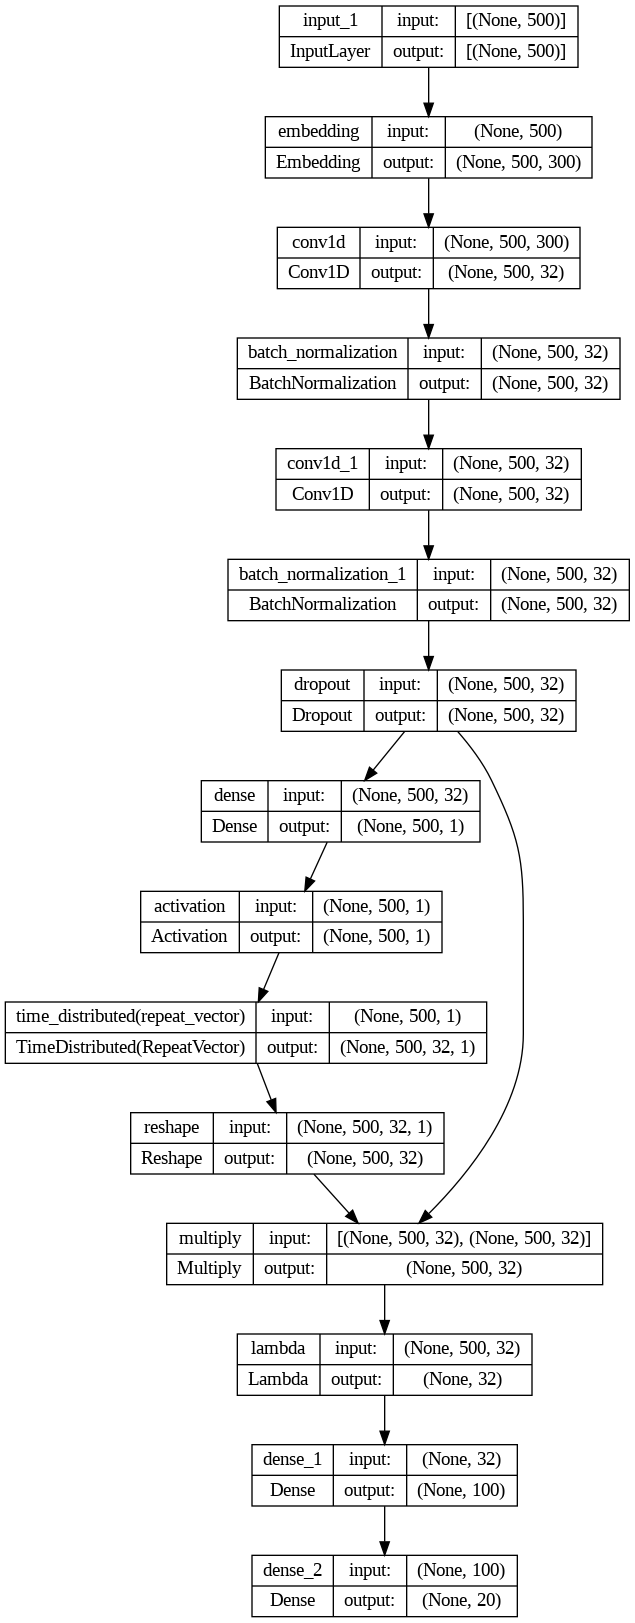

In [ ]:
plot_model(model, to_file = "model.png", expand_nested = True, show_shapes = True)

In [ ]:
opt = optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model.fit(train_sequences, newsgroups_train.target, batch_size=256, epochs=30, validation_split=0.2)

Epoch 1/30
36/36 [==============================] - 32s 397ms/step - loss: 2.7989 - accuracy: 0.1550 - val_loss: 2.9519 - val_accuracy: 0.1445
Epoch 2/30
36/36 [==============================] - 9s 247ms/step - loss: 1.7841 - accuracy: 0.4845 - val_loss: 2.8273 - val_accuracy: 0.1361
Epoch 3/30
36/36 [==============================] - 9s 251ms/step - loss: 0.9433 - accuracy: 0.7099 - val_loss: 2.6450 - val_accuracy: 0.2267
Epoch 4/30
36/36 [==============================] - 9s 256ms/step - loss: 0.5755 - accuracy: 0.8300 - val_loss: 2.2284 - val_accuracy: 0.4331
Epoch 5/30
36/36 [==============================] - 10s 262ms/step - loss: 0.3433 - accuracy: 0.9041 - val_loss: 1.6115 - val_accuracy: 0.6306
Epoch 6/30
36/36 [==============================] - 7s 192ms/step - loss: 0.2418 - accuracy: 0.9321 - val_loss: 1.0136 - val_accuracy: 0.7729
Epoch 7/30
36/36 [==============================] - 10s 294ms/step - loss: 0.1512 - accuracy: 0.9613 - val_loss: 0.7122 - val_accuracy: 0.8387
Epo

# $\textit{Embedding + Bidir RNN + Attention}$

In [ ]:
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Input, Concatenate,Dot,RepeatVector,TimeDistributed,Multiply,Lambda,Bidirectional, LSTM, Activation, Reshape
import tensorflow.keras.backend as K
from tensorflow.keras.activations import softmax
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

def softMaxOverTime(x):
    return softmax(x, axis=0)

value_dim = 100 #Tamaño de los estados del contextualizador
nb_words = num_words #Vocabulary size

input_layer = Input(shape=(max_len,)) #Cantidad maxima de la frase de entrada, estos son los timesteps para este caso
embedding_layer = Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(input_layer)

#Contextualizador BidirRNN
lstm_out = Bidirectional(LSTM(value_dim, return_sequences=True, activation="tanh"), merge_mode="concat")(embedding_layer)
lstm_out = BatchNormalization()(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)
ulog_attention = Dense(1, activation="linear")(lstm_out)

#Attention
attention = Activation(softMaxOverTime)(ulog_attention)
repeated_attention = TimeDistributed(RepeatVector(value_dim*2))(attention)
repeated_attention = Reshape([max_len, value_dim*2])(repeated_attention)

#Pesamos el embedding con el score
weighted_embeddings = Multiply()([repeated_attention, lstm_out])
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

#Salida
dense1 = Dense(100, activation='relu', kernel_regularizer=regularizers.L1())(embedding_sum)
dense2 = Dense(20, activation='softmax')(dense1)
model = Model(input_layer , dense2)

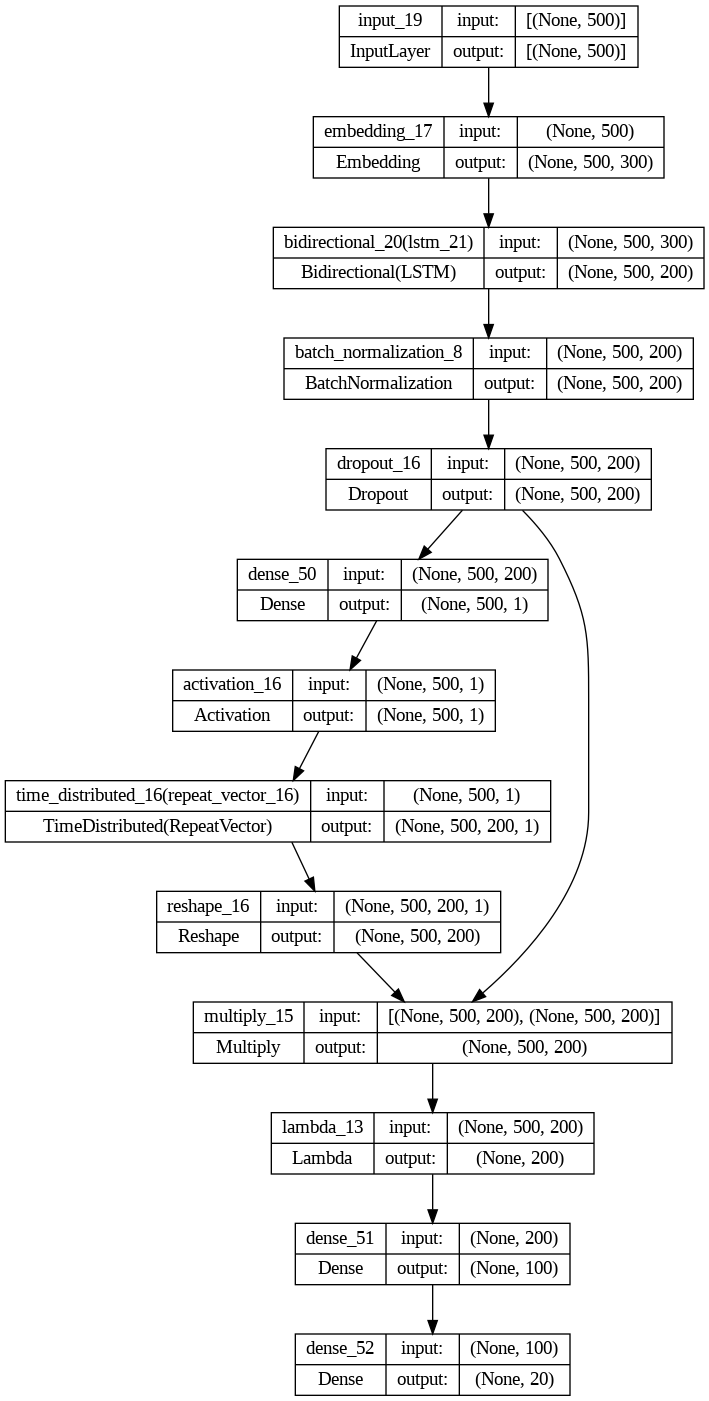

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
opt = optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model.fit(train_sequences, newsgroups_train.target, batch_size=256, epochs=25, validation_split=0.2)

Epoch 1/25
36/36 [==============================] - 30s 322ms/step - loss: 10.2553 - accuracy: 0.1119 - val_loss: 5.8233 - val_accuracy: 0.0570
Epoch 2/25
36/36 [==============================] - 11s 297ms/step - loss: 3.3058 - accuracy: 0.4632 - val_loss: 3.7937 - val_accuracy: 0.0924
Epoch 3/25
36/36 [==============================] - 11s 295ms/step - loss: 1.5866 - accuracy: 0.7927 - val_loss: 3.1028 - val_accuracy: 0.2572
Epoch 4/25
36/36 [==============================] - 9s 261ms/step - loss: 0.8311 - accuracy: 0.9305 - val_loss: 2.7610 - val_accuracy: 0.4428
Epoch 5/25
36/36 [==============================] - 11s 301ms/step - loss: 0.5903 - accuracy: 0.9696 - val_loss: 2.2100 - val_accuracy: 0.5762
Epoch 6/25
36/36 [==============================] - 9s 264ms/step - loss: 0.4062 - accuracy: 0.9902 - val_loss: 1.9827 - val_accuracy: 0.5917
Epoch 7/25
36/36 [==============================] - 9s 263ms/step - loss: 0.3449 - accuracy: 0.9954 - val_loss: 1.6089 - val_accuracy: 0.7362
E

# $\textit{Conclusiones}$

Luego de haber comprendido el funcionamiento de las redes anteriormente presentadas, llegamos a varias conclusiones al respecto. En primer lugar, encontramos que las redes logran *overfittear* a los datos rápidamente. Para evitar el *overfitting*, se probaron distintos métodos de regularización cómo el L1, L2 y el *dropout*, siendo este último el que mejor resultados nos dió. Así mismo, se modificó la complejidad de las redes para obtener redes que nos den resultados en validación mejores, obteniendo valores de accuracy más altos que los iniciales.

Respecto a los contextualizadores probados, en ambos casos se obtuvo una mejor *performance* entrenando la capa de *embeddings*. En base al entrenamiento, notamos que las RNN requieren un tiempo de cómputo considerablemente mayor a las CNN. Cabe destacar que se obtuvo un *accuracy* muy similar entre las CNN y las RNN. Debido al tiempo de cálculo necesario para entrenar las unidades LSTM, se dificultó realizar más pruebas y probar otras configuraciones para mejorar su *performance*.

En conclusión, el trabajo realizado fué enriquecedor para entender cómo funcionan los mecanismos de *attention* y cómo pueden ser utilizados para realizar clasificación de textos.